In [1]:
import numpy as np
import pandas as pd
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import make_scorer, confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from joblib import dump, load

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../../data/processed/WESAD/data_processed/30s/addon_feature_data.csv' ,index_col=0)
df.head()

,ACC_x_mean,ACC_y_mean,ACC_z_mean,net_acc_mean,net_acc_std,EDA_mean,EDA_std,EDA_slope,RESP_rate,RESP_regularity,...,EDA_mean_clip,EDA_slope_log,EDA_slope_pos,eda_hr_interaction,eda_resp_ratio,hr_resp_interaction,hr_resp_z_interaction,hrv_composite,hrv_stress_index,arousal_index
0,39.628667,-46.246667,9.764000,62.469299,1.120992,0.523506,0.009367,-0.000265,21.327375,1.591487,...,0.523506,-0.000265,0,34.746298,0.005886,1415.545722,-0.035662,96.253149,0.595642,741.047339
1,38.927333,-48.439333,6.083333,62.442314,0.428267,0.520051,0.018623,0.000048,22.168906,1.352590,...,0.520051,0.000048,1,40.870200,0.013768,1742.228749,0.007070,124.282730,0.976977,906.047629
2,38.919333,-47.006667,-0.914667,62.576766,1.166077,0.493109,0.007353,-0.000203,24.011434,1.809602,...,0.493109,-0.000203,0,32.095491,0.004064,1562.857969,-1.403354,132.380562,0.676597,770.658757
3,49.157333,-18.907333,31.472000,62.762208,1.500866,0.470519,0.010338,-0.000283,20.909046,1.358827,...,0.470519,-0.000283,0,30.942103,0.007608,1375.012643,0.164330,98.535106,0.650496,646.969837
4,46.228000,-39.174667,13.782000,62.674127,1.910619,0.442887,0.007276,-0.000196,22.165715,1.926374,...,0.442887,-0.000196,0,33.749942,0.003777,1689.123832,-0.076409,116.329704,1.112837,748.091592


In [4]:
df = df.drop(df[df['subject']==15].index)

In [5]:
selected_feature = ['EDA_mean', 'EDA_std', 'EDA_slope', 'RESP_rate', 'RESP_regularity',
       'HR', 'RMSSD', 'SDNN', 'pNN50', 'hr_diff', 'hr_center', 'hr_slope',
       'hr_resp_interaction', 'hr_resp_z_interaction', 'hrv_stress_index']

In [6]:
X = df[selected_feature]
y = df['focus_label']

In [7]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=50, random_state=42))
])

In [8]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [9]:
y_pred = cross_val_predict(pipeline, X, y, cv=skf)

In [10]:
focus_precision = cross_val_score(pipeline, X, y, cv=skf, scoring=make_scorer(precision_score, pos_label=1))
focus_recall = cross_val_score(pipeline, X, y, cv=skf, scoring=make_scorer(recall_score, pos_label=1))
f1_macro = cross_val_score(pipeline, X, y, cv=skf, scoring='f1_macro')
focus_f1 = cross_val_score(pipeline, X, y, cv=skf, scoring=make_scorer(f1_score, pos_label=1))

In [11]:
print("CV 5 fold Precision score:\t", focus_precision.mean())
print("CV 5 fold recall score:\t\t", focus_recall.mean())
print("CV 5 fold F1 score:\t\t", f1_macro.mean())
print("CV 5 fold macro F1 score:\t", f1_macro.mean())

CV 5 fold Precision score:	 0.8607610951102643
CV 5 fold recall score:		 0.9393939393939394
CV 5 fold F1 score:		 0.8611707865571774
CV 5 fold macro F1 score:	 0.8611707865571774


In [12]:
print(classification_report(y_true=y, y_pred=y_pred, target_names=["Not Focus", "Focus"]))

              precision    recall  f1-score   support

   Not Focus       0.89      0.77      0.83       326
       Focus       0.86      0.94      0.90       495

    accuracy                           0.87       821
   macro avg       0.88      0.85      0.86       821
weighted avg       0.87      0.87      0.87       821



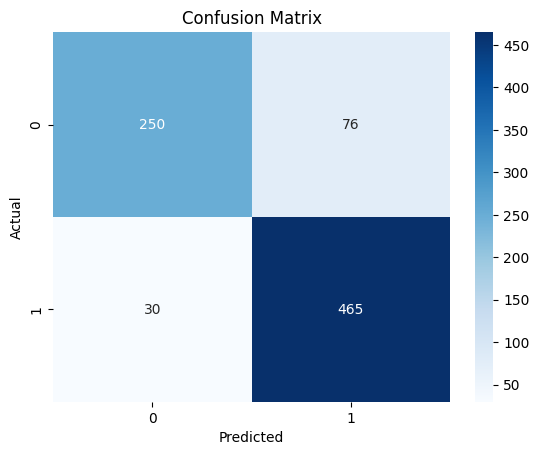

In [13]:
cm = confusion_matrix(y, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Gridsearch

In [14]:
param_grid = {
    'rf__n_estimators': [50, 100, 150],
    'rf__max_depth': [None, 5, 10],
    'rf__min_samples_split': [2, 5],
}

In [15]:
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=skf,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

In [16]:
grid_search.fit(X, y)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(n_estimators=50,
                                                               random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 5, 10],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [50, 100, 150]},
             scoring='f1_macro', verbose=1)

In [17]:
print("Best Parameters:", grid_search.best_params_)
print("Best Score (F1 macro):", grid_search.best_score_)

Best Parameters: {'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
Best Score (F1 macro): 0.8611707865571774


## Feature importance using SHAP

In [18]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(max_depth=None, min_samples_split=2, n_estimators=100, random_state=42))
])

In [19]:
pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('rf', RandomForestClassifier(random_state=42))])

In [20]:
X_scaled = pipeline.named_steps['scaler'].transform(X)
explainer = shap.TreeExplainer(pipeline.named_steps['rf'], X)
shap_values = explainer(X_scaled)

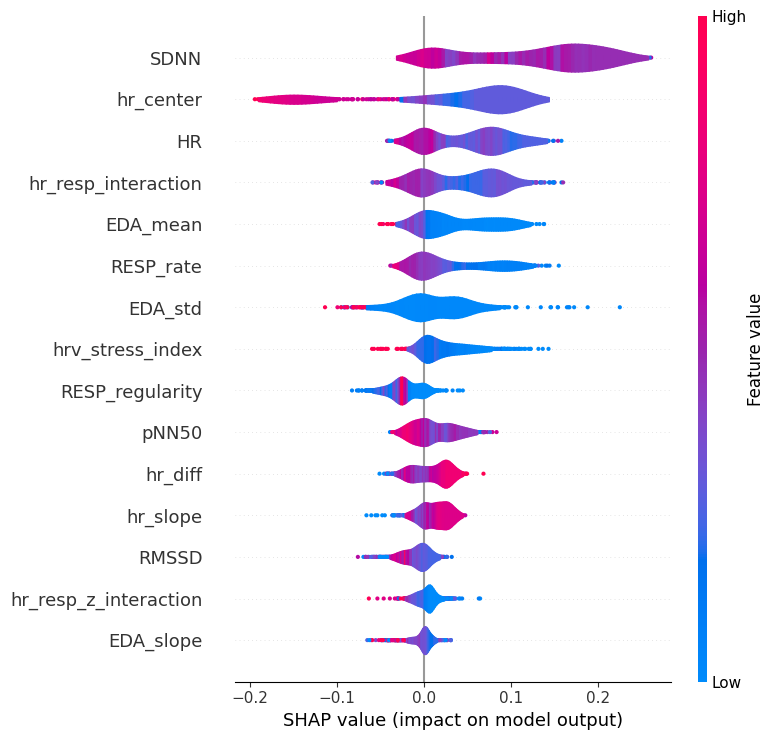

In [21]:
shap.summary_plot(
    shap_values[:, :, 1],
    plot_type='violin',
    feature_names=X.columns
)